In [1]:
# library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from slice_ojh import split_stock, split_mm
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

import re
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [35]:
x = np.load('x_data.npy', allow_pickle = 'True')

In [36]:
# data preprocess
def prepro(data, method):
    if method == 'minmax':
        scaler = MinMaxScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'stand':
        scaler = StandardScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)
    
    if method == 'robust':
        scaler = RobustScaler()
        x = data.reshape(-1,1)
        scaler.fit(x)
        tmp = scaler.transform(x)
        return np.squeeze(tmp, axis=1)

### Xgboost

(556, 25) (556, 1)
(500, 25) (500, 1)
(56, 25) (56, 1)


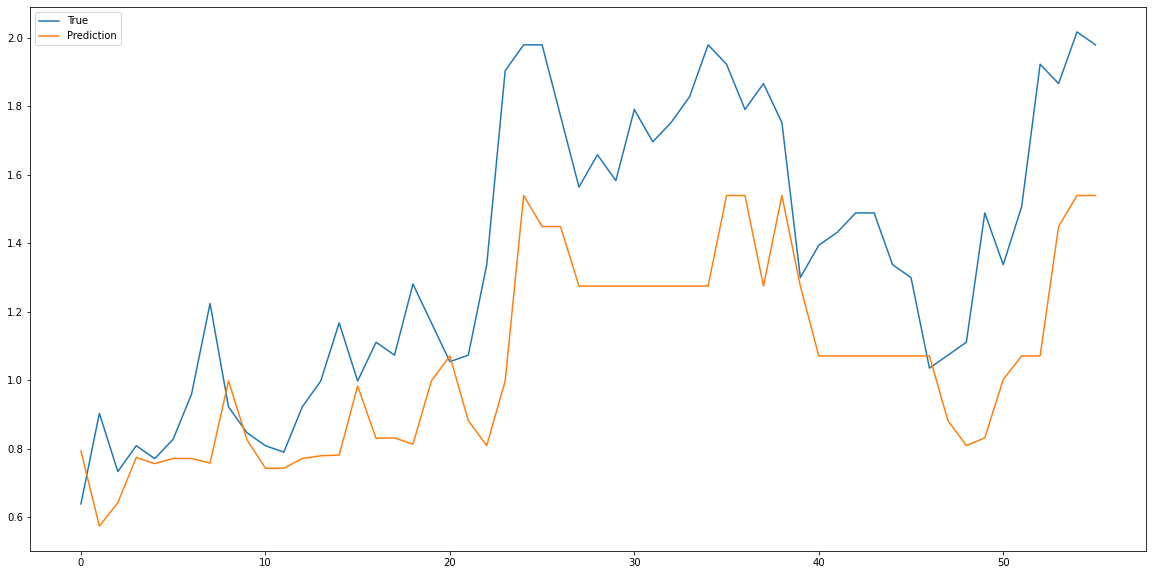

In [37]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

# close data
features, labels = split_mm(x_stand, 25, 1)
print(features.shape, labels.shape)

# split data
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# training Xgboost
xgb = XGBRegressor(learning_rate=0.01, n_estimators=100, max_depth=5, random_state=3)
xgb_fit = xgb.fit(x_train, y_train)

# predict
xgb_pred = xgb.predict(x_test)

# plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(xgb_pred, label='Prediction')
ax.legend()
plt.show()

RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x0000028D967B96C8>,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.01, max_delta_step=0,
                                          max_depth=5, min_child_weight=1,
                                          missing=nan,
                                          monotone_...
                                          tree_method='exact',
                                          validate_parameters=1,
                                          verbosity=None),
                   param_distributions={'co

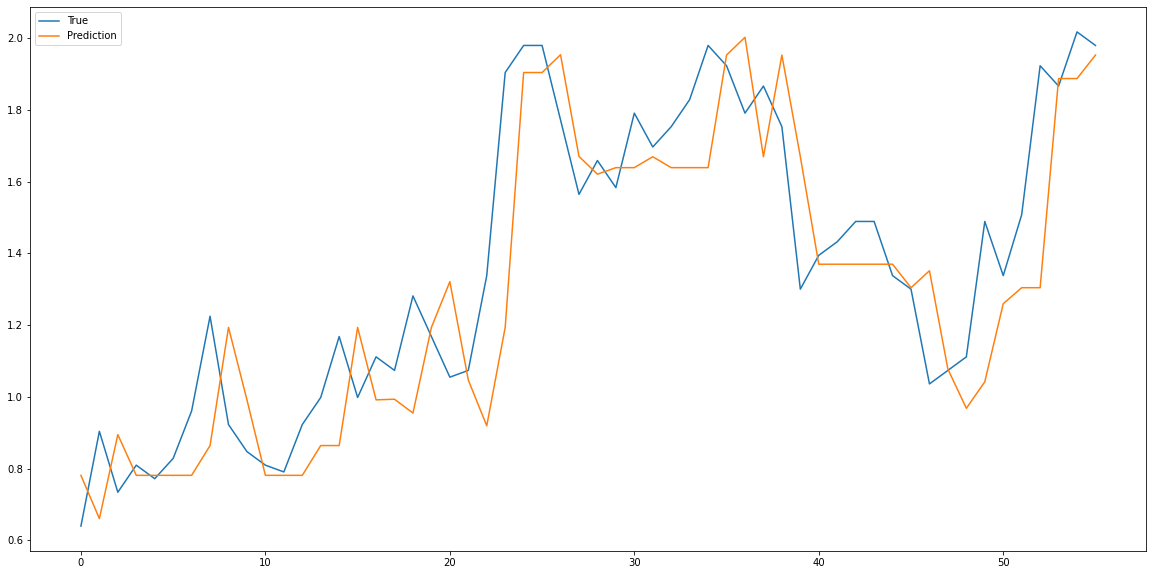

In [145]:
# Xgboost hyperparameter
params = {
    'learning_rate':[0.01,0.05,0.1,0.15,0.2],
    'n_estimators':[50,100,150,200],
    'max_depth':[3,5,7,9],
    'subsample':[0.6,0.8,1.0],
    'min_child_weight':[1,5,10],
    'gamma':[0.5,1,1.5,2],
    'max_delta_step':[1,3,5,7,9],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'colsample_bytree':[0.6,0.7,0.8,0.9,1.0]}
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(xgb, params, cv=time_cv)
best_xgb = search.fit(x_train, y_train, verbose=2)
best_param = search.best_params_
print(best_xgb)
print(best_param)

best_pred = best_xgb.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

In [146]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)
x_stand = np.squeeze(tmp, axis=1)

In [147]:
# today close
x_today = x_stand[-25:]
x_today = x_today[np.newaxis,:]
tmp = best_xgb.predict(x_today)
print(tmp)
pred_today = scaler.inverse_transform(tmp)
print(pred_today)

[1.9366989]
[58773.414]


In [148]:
# atfer 2day
x_today2 = x_stand[-24:]
x_today2 = np.append(x_today2, tmp)
x_today2 = x_today2[np.newaxis,:]
tmp2= best_xgb.predict(x_today2)
print(tmp2)
pred_today2 = scaler.inverse_transform(tmp2)
print(pred_today2)

[2.002194]
[59120.46]


In [149]:
# atfer 3day
x_today3 = x_stand[-23:]
x_today3 = np.append(x_today3, tmp)
x_today3 = np.append(x_today3, tmp2)
x_today3 = x_today3[np.newaxis,:]
tmp3 = best_xgb.predict(x_today3)
print(tmp3)
pred_today = scaler.inverse_transform(tmp3)
print(pred_today)

[1.9526659]
[58858.02]


In [83]:
# atfer 4day
x_today4 = x_stand[-22:]
x_today4 = np.append(x_today4, tmp)
x_today4 = np.append(x_today4, tmp2)
x_today4 = np.append(x_today4, tmp3)
x_today4 = x_today4[np.newaxis,:]
tmp3 = best_xgb.predict(x_today4)
print(tmp3)
pred_today = scaler.inverse_transform(tmp3)
print(pred_today)

[1.9923083]
[59068.08]


In [84]:
print(x_today.shape)
print(x_today)
print(x_today4)
print(x_today4.shape)

(1, 25)
[[1.69637652 1.75299332 1.8284824  1.97946054 1.92284374 1.79073786
  1.86622693 1.75299332 1.30005889 1.39442023 1.43216477 1.48878157
  1.48878157 1.33780343 1.30005889 1.03584714 1.07359168 1.11133621
  1.48878157 1.33780343 1.50765384 1.92284374 1.86622693 2.01720508
  1.97946054]]
[[1.97946054 1.92284374 1.79073786 1.86622693 1.75299332 1.30005889
  1.39442023 1.43216477 1.48878157 1.48878157 1.33780343 1.30005889
  1.03584714 1.07359168 1.11133621 1.48878157 1.33780343 1.50765384
  1.92284374 1.86622693 2.01720508 1.97946054 2.01476002 2.01476002
  2.01476002]]
(1, 25)


### LSTM

In [152]:
# data preprocess
x_stand = np.zeros((x.shape[0], x.shape[1]))
for i in range(len(x[0])):
    x_stand[:,i] = prepro(x[:,i], 'stand')

# data slice
features, labels = split_stock(x_stand, 25, 3, 3)
print(features.shape, labels.shape)

(554, 25, 5) (554, 3)


In [153]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(498, 25, 5) (498, 3)
(56, 25, 5) (56, 3)


In [154]:
# LSTM model
def LSTM_model(drop=0.5, optimizer = 'adam'):
    inputs = Input(shape= (25,5), name = 'input')
    x = LSTM(512, activation = 'relu', name = 'hidden1', return_sequences=True)(inputs)
    x = Dropout(drop)(x)
    x = LSTM(256, activation = 'relu', name = 'hidden1')(inputs)
    x = Dropout(drop)(x)
    x = Dense(100, activation = 'relu', name = 'hidden2')(x)
    x = Dropout(drop)(x)
    x = Dense(20, activation = 'relu', name = 'hidden3')(x)
    x = Dropout(drop)(x)
    #x = Dense(20, activation = 'relu', name = 'hidden4')(x)
    #x = Dropout(drop)(x)
    outputs = Dense(3, name = 'output')(x)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mse'])
    return model

# parameter
def create_hyperparameters(): # epochs, node, acivation 추가 가능
    batches = [16, 32, 64]
    optimizers = ['rmsprop', 'adam', 'adadelta']
    dropout = [0.1, 0.2, 0.3, 0.4, 0.5]                           
    return {'batch_size' : batches, 'optimizer': optimizers, 
           'drop': dropout}

# wrapper
model = KerasRegressor(build_fn = LSTM_model, verbose = 2)

In [155]:
hyperparameters = create_hyperparameters()
time_cv = TimeSeriesSplit(n_splits=5).split(x_train)
search = RandomizedSearchCV(model, hyperparameters, cv = time_cv)

best_LSTM = search.fit(x_train, y_train, epochs=30, verbose=2)
best_param = search.best_params_
print(best_LSTM)
print(best_param)

best_pred = best_LSTM.predict(x_test)

# plotting
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(best_pred, label='Prediction')
ax.legend()
plt.show()

Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2382 - mse: 0.2382
Epoch 2/30
83/83 - 0s - loss: 0.1371 - mse: 0.1371
Epoch 3/30
83/83 - 0s - loss: 0.0807 - mse: 0.0807
Epoch 4/30
83/83 - 0s - loss: 0.0587 - mse: 0.0587
Epoch 5/30
83/83 - 0s - loss: 0.0557 - mse: 0.0557
Epoch 6/30
83/83 - 0s - loss: 0.0478 - mse: 0.0478
Epoch 7/30
83/83 - 0s - loss: 0.0533 - mse: 0.0533
Epoch 8/30
83/83 - 0s - loss: 0.0529 - mse: 0.0529
Epoch 9/30
83/83 - 0s - loss: 0.0431 - mse: 0.0431
Epoch 10/30
83/83 - 0s - loss: 0.0480 - mse: 0.0480
Epoch 11/30
83/83 - 0s - loss: 0.0458 - mse: 0.0458
Epoch 12/30
83/83 - 0s - loss: 0.0459 - mse: 0.0459
Epoch 13/30
83/83 - 0s - loss: 0.0467 - mse: 0.0467
Epoch 14/30
83/83 - 0s - loss: 0.0451 - mse: 0.0451
Epoch 15/30
83/83 - 0s - loss: 0.0438 - mse: 0.0438
Epoch 16/30
83/83 - 0s - loss: 0.0437 - mse: 0.0437
Epoch 17/30
83/83 - 0s - loss: 0.0422 - mse: 0.0422
Epoch 18/30
83/83 - 0s - loss: 0.0405 - mse: 0.0405
Epoch 19/30
83/83 - 0s - loss: 0.0489 - mse: 0.0489
E

Epoch 30/30
415/415 - 1s - loss: 0.0725 - mse: 0.0725
83/1 - 0s - loss: 0.6897 - mse: 0.8829
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2761 - mse: 0.2761
Epoch 2/30
83/83 - 0s - loss: 0.2776 - mse: 0.2776
Epoch 3/30
83/83 - 0s - loss: 0.2792 - mse: 0.2792
Epoch 4/30
83/83 - 0s - loss: 0.2746 - mse: 0.2746
Epoch 5/30
83/83 - 0s - loss: 0.2783 - mse: 0.2783
Epoch 6/30
83/83 - 0s - loss: 0.2746 - mse: 0.2746
Epoch 7/30
83/83 - 0s - loss: 0.2787 - mse: 0.2787
Epoch 8/30
83/83 - 0s - loss: 0.2756 - mse: 0.2756
Epoch 9/30
83/83 - 0s - loss: 0.2785 - mse: 0.2785
Epoch 10/30
83/83 - 0s - loss: 0.2738 - mse: 0.2738
Epoch 11/30
83/83 - 0s - loss: 0.2766 - mse: 0.2766
Epoch 12/30
83/83 - 0s - loss: 0.2771 - mse: 0.2771
Epoch 13/30
83/83 - 0s - loss: 0.2765 - mse: 0.2765
Epoch 14/30
83/83 - 0s - loss: 0.2776 - mse: 0.2776
Epoch 15/30
83/83 - 0s - loss: 0.2773 - mse: 0.2773
Epoch 16/30
83/83 - 0s - loss: 0.2753 - mse: 0.2753
Epoch 17/30
83/83 - 0s - loss: 0.2775 - mse: 0.2775
Epoch 18/30


415/415 - 1s - loss: 0.9826 - mse: 0.9826
Epoch 29/30
415/415 - 1s - loss: 0.9801 - mse: 0.9801
Epoch 30/30
415/415 - 1s - loss: 0.9780 - mse: 0.9780
83/1 - 0s - loss: 0.5886 - mse: 0.4913
Train on 83 samples
Epoch 1/30
83/83 - 3s - loss: 0.2492 - mse: 0.2492
Epoch 2/30
83/83 - 0s - loss: 0.4340 - mse: 0.4340
Epoch 3/30
83/83 - 0s - loss: 0.1556 - mse: 0.1556
Epoch 4/30
83/83 - 0s - loss: 0.1431 - mse: 0.1431
Epoch 5/30
83/83 - 0s - loss: 0.1302 - mse: 0.1302
Epoch 6/30
83/83 - 0s - loss: 0.1234 - mse: 0.1234
Epoch 7/30
83/83 - 0s - loss: 0.1221 - mse: 0.1221
Epoch 8/30
83/83 - 0s - loss: 0.1062 - mse: 0.1062
Epoch 9/30
83/83 - 0s - loss: 0.0970 - mse: 0.0970
Epoch 10/30
83/83 - 0s - loss: 0.0988 - mse: 0.0988
Epoch 11/30
83/83 - 0s - loss: 0.0913 - mse: 0.0913
Epoch 12/30
83/83 - 0s - loss: 0.0735 - mse: 0.0735
Epoch 13/30
83/83 - 0s - loss: 0.0698 - mse: 0.0698
Epoch 14/30
83/83 - 0s - loss: 0.0761 - mse: 0.0761
Epoch 15/30
83/83 - 0s - loss: 0.0763 - mse: 0.0763
Epoch 16/30
83/83 - 

Epoch 27/30
415/415 - 1s - loss: 0.1331 - mse: 0.1331
Epoch 28/30
415/415 - 1s - loss: 0.1138 - mse: 0.1138
Epoch 29/30
415/415 - 1s - loss: 0.1271 - mse: 0.1271
Epoch 30/30
415/415 - 1s - loss: 0.1139 - mse: 0.1139
83/1 - 0s - loss: 2.0277 - mse: 3.4101
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2907 - mse: 0.2907
Epoch 2/30
83/83 - 0s - loss: 0.2883 - mse: 0.2883
Epoch 3/30
83/83 - 0s - loss: 0.2898 - mse: 0.2898
Epoch 4/30
83/83 - 0s - loss: 0.2969 - mse: 0.2969
Epoch 5/30
83/83 - 0s - loss: 0.2916 - mse: 0.2916
Epoch 6/30
83/83 - 0s - loss: 0.2912 - mse: 0.2912
Epoch 7/30
83/83 - 0s - loss: 0.2917 - mse: 0.2917
Epoch 8/30
83/83 - 0s - loss: 0.2899 - mse: 0.2899
Epoch 9/30
83/83 - 0s - loss: 0.2908 - mse: 0.2908
Epoch 10/30
83/83 - 0s - loss: 0.2905 - mse: 0.2905
Epoch 11/30
83/83 - 0s - loss: 0.2898 - mse: 0.2898
Epoch 12/30
83/83 - 0s - loss: 0.2899 - mse: 0.2899
Epoch 13/30
83/83 - 0s - loss: 0.2876 - mse: 0.2876
Epoch 14/30
83/83 - 0s - loss: 0.2915 - mse: 0.2915
Epoch 

415/415 - 1s - loss: 1.0005 - mse: 1.0005
Epoch 26/30
415/415 - 1s - loss: 0.9981 - mse: 0.9981
Epoch 27/30
415/415 - 1s - loss: 0.9952 - mse: 0.9952
Epoch 28/30
415/415 - 1s - loss: 1.0022 - mse: 1.0022
Epoch 29/30
415/415 - 1s - loss: 0.9872 - mse: 0.9872
Epoch 30/30
415/415 - 1s - loss: 0.9859 - mse: 0.9859
83/1 - 0s - loss: 0.5924 - mse: 0.4840
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2674 - mse: 0.2674
Epoch 2/30
83/83 - 0s - loss: 0.2275 - mse: 0.2275
Epoch 3/30
83/83 - 0s - loss: 0.1855 - mse: 0.1855
Epoch 4/30
83/83 - 0s - loss: 0.1498 - mse: 0.1498
Epoch 5/30
83/83 - 0s - loss: 0.1522 - mse: 0.1522
Epoch 6/30
83/83 - 0s - loss: 0.1507 - mse: 0.1507
Epoch 7/30
83/83 - 0s - loss: 0.1463 - mse: 0.1463
Epoch 8/30
83/83 - 0s - loss: 0.1073 - mse: 0.1073
Epoch 9/30
83/83 - 0s - loss: 0.1311 - mse: 0.1311
Epoch 10/30
83/83 - 0s - loss: 0.1125 - mse: 0.1125
Epoch 11/30
83/83 - 0s - loss: 0.1192 - mse: 0.1192
Epoch 12/30
83/83 - 0s - loss: 0.1127 - mse: 0.1127
Epoch 13/30
83

Epoch 24/30
415/415 - 1s - loss: 0.2694 - mse: 0.2694
Epoch 25/30
415/415 - 1s - loss: 0.3033 - mse: 0.3033
Epoch 26/30
415/415 - 1s - loss: 0.2728 - mse: 0.2728
Epoch 27/30
415/415 - 1s - loss: 0.2759 - mse: 0.2759
Epoch 28/30
415/415 - 1s - loss: 0.2649 - mse: 0.2649
Epoch 29/30
415/415 - 1s - loss: 0.2828 - mse: 0.2828
Epoch 30/30
415/415 - 1s - loss: 0.2958 - mse: 0.2958
83/1 - 0s - loss: 0.4666 - mse: 0.6153
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2271 - mse: 0.2271
Epoch 2/30
83/83 - 0s - loss: 0.1308 - mse: 0.1308
Epoch 3/30
83/83 - 0s - loss: 0.1030 - mse: 0.1030
Epoch 4/30
83/83 - 0s - loss: 0.1066 - mse: 0.1066
Epoch 5/30
83/83 - 0s - loss: 0.0915 - mse: 0.0915
Epoch 6/30
83/83 - 0s - loss: 0.1009 - mse: 0.1009
Epoch 7/30
83/83 - 0s - loss: 0.0899 - mse: 0.0899
Epoch 8/30
83/83 - 0s - loss: 0.0786 - mse: 0.0786
Epoch 9/30
83/83 - 0s - loss: 0.1250 - mse: 0.1250
Epoch 10/30
83/83 - 0s - loss: 0.0819 - mse: 0.0819
Epoch 11/30
83/83 - 0s - loss: 0.1081 - mse: 0.1081


415/415 - 1s - loss: 0.3140 - mse: 0.3140
Epoch 23/30
415/415 - 1s - loss: 0.2811 - mse: 0.2811
Epoch 24/30
415/415 - 1s - loss: 0.3039 - mse: 0.3039
Epoch 25/30
415/415 - 1s - loss: 0.2809 - mse: 0.2809
Epoch 26/30
415/415 - 1s - loss: 0.2508 - mse: 0.2508
Epoch 27/30
415/415 - 1s - loss: 0.2875 - mse: 0.2875
Epoch 28/30
415/415 - 1s - loss: 0.3119 - mse: 0.3119
Epoch 29/30
415/415 - 1s - loss: 0.2680 - mse: 0.2680
Epoch 30/30
415/415 - 1s - loss: 0.2877 - mse: 0.2877
83/1 - 0s - loss: 36.4716 - mse: 72.4950
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.1340 - mse: 0.1340
Epoch 2/30
83/83 - 0s - loss: 0.0692 - mse: 0.0692
Epoch 3/30
83/83 - 0s - loss: 0.0549 - mse: 0.0549
Epoch 4/30
83/83 - 0s - loss: 0.0581 - mse: 0.0581
Epoch 5/30
83/83 - 0s - loss: 0.0664 - mse: 0.0664
Epoch 6/30
83/83 - 0s - loss: 0.0590 - mse: 0.0590
Epoch 7/30
83/83 - 0s - loss: 0.0421 - mse: 0.0421
Epoch 8/30
83/83 - 0s - loss: 0.0479 - mse: 0.0479
Epoch 9/30
83/83 - 0s - loss: 0.0533 - mse: 0.0533
Epoch 

Epoch 21/30
415/415 - 1s - loss: 0.0768 - mse: 0.0768
Epoch 22/30
415/415 - 1s - loss: 0.0739 - mse: 0.0739
Epoch 23/30
415/415 - 1s - loss: 0.0792 - mse: 0.0792
Epoch 24/30
415/415 - 1s - loss: 0.0709 - mse: 0.0709
Epoch 25/30
415/415 - 1s - loss: 0.0736 - mse: 0.0736
Epoch 26/30
415/415 - 2s - loss: 0.0701 - mse: 0.0701
Epoch 27/30
415/415 - 1s - loss: 0.0713 - mse: 0.0713
Epoch 28/30
415/415 - 1s - loss: 0.0690 - mse: 0.0690
Epoch 29/30
415/415 - 1s - loss: 0.0639 - mse: 0.0639
Epoch 30/30
415/415 - 1s - loss: 0.0627 - mse: 0.0627
83/1 - 0s - loss: 0.2316 - mse: 0.3674
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.1937 - mse: 0.1937
Epoch 2/30
83/83 - 0s - loss: 0.1132 - mse: 0.1132
Epoch 3/30
83/83 - 0s - loss: 0.1159 - mse: 0.1159
Epoch 4/30
83/83 - 0s - loss: 0.0818 - mse: 0.0818
Epoch 5/30
83/83 - 0s - loss: 0.1043 - mse: 0.1043
Epoch 6/30
83/83 - 0s - loss: 0.0843 - mse: 0.0843
Epoch 7/30
83/83 - 0s - loss: 0.0723 - mse: 0.0723
Epoch 8/30
83/83 - 0s - loss: 0.0585 - mse: 

415/415 - 1s - loss: 0.2024 - mse: 0.2024
Epoch 20/30
415/415 - 1s - loss: 0.2016 - mse: 0.2016
Epoch 21/30
415/415 - 1s - loss: 0.1997 - mse: 0.1997
Epoch 22/30
415/415 - 1s - loss: 0.1783 - mse: 0.1783
Epoch 23/30
415/415 - 1s - loss: 0.1870 - mse: 0.1870
Epoch 24/30
415/415 - 1s - loss: 0.2223 - mse: 0.2223
Epoch 25/30
415/415 - 1s - loss: 0.1845 - mse: 0.1845
Epoch 26/30
415/415 - 1s - loss: 0.1602 - mse: 0.1602
Epoch 27/30
415/415 - 1s - loss: 0.1970 - mse: 0.1970
Epoch 28/30
415/415 - 1s - loss: 0.1723 - mse: 0.1723
Epoch 29/30
415/415 - 1s - loss: 0.1849 - mse: 0.1849
Epoch 30/30
415/415 - 1s - loss: 0.1685 - mse: 0.1685
83/1 - 0s - loss: 2.7517 - mse: 4.8679
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2273 - mse: 0.2273
Epoch 2/30
83/83 - 0s - loss: 0.1456 - mse: 0.1456
Epoch 3/30
83/83 - 0s - loss: 0.1534 - mse: 0.1534
Epoch 4/30
83/83 - 0s - loss: 0.1400 - mse: 0.1400
Epoch 5/30
83/83 - 0s - loss: 0.1027 - mse: 0.1027
Epoch 6/30
83/83 - 0s - loss: 0.1097 - mse: 0.1097

Epoch 18/30
415/415 - 1s - loss: 0.2958 - mse: 0.2958
Epoch 19/30
415/415 - 1s - loss: 0.2786 - mse: 0.2786
Epoch 20/30
415/415 - 1s - loss: 0.2959 - mse: 0.2959
Epoch 21/30
415/415 - 1s - loss: 0.2886 - mse: 0.2886
Epoch 22/30
415/415 - 1s - loss: 0.2760 - mse: 0.2760
Epoch 23/30
415/415 - 1s - loss: 0.2771 - mse: 0.2771
Epoch 24/30
415/415 - 1s - loss: 0.2796 - mse: 0.2796
Epoch 25/30
415/415 - 1s - loss: 0.2771 - mse: 0.2771
Epoch 26/30
415/415 - 1s - loss: 0.2450 - mse: 0.2450
Epoch 27/30
415/415 - 1s - loss: 0.2736 - mse: 0.2736
Epoch 28/30
415/415 - 1s - loss: 0.2368 - mse: 0.2368
Epoch 29/30
415/415 - 1s - loss: 0.2510 - mse: 0.2510
Epoch 30/30
415/415 - 1s - loss: 0.3298 - mse: 0.3298
83/1 - 2s - loss: 0.4875 - mse: 0.6447
Train on 83 samples
Epoch 1/30
83/83 - 1s - loss: 0.2980 - mse: 0.2980
Epoch 2/30
83/83 - 0s - loss: 0.2982 - mse: 0.2982
Epoch 3/30
83/83 - 0s - loss: 0.2940 - mse: 0.2940
Epoch 4/30
83/83 - 0s - loss: 0.2975 - mse: 0.2975
Epoch 5/30
83/83 - 0s - loss: 0.291

415/415 - 1s - loss: 0.9859 - mse: 0.9859
Epoch 17/30
415/415 - 1s - loss: 0.9916 - mse: 0.9916
Epoch 18/30
415/415 - 1s - loss: 0.9796 - mse: 0.9796
Epoch 19/30
415/415 - 1s - loss: 0.9805 - mse: 0.9805
Epoch 20/30
415/415 - 1s - loss: 0.9746 - mse: 0.9746
Epoch 21/30
415/415 - 1s - loss: 0.9746 - mse: 0.9746
Epoch 22/30
415/415 - 1s - loss: 0.9656 - mse: 0.9656
Epoch 23/30
415/415 - 1s - loss: 0.9819 - mse: 0.9819
Epoch 24/30
415/415 - 1s - loss: 0.9727 - mse: 0.9727
Epoch 25/30
415/415 - 1s - loss: 0.9760 - mse: 0.9760
Epoch 26/30
415/415 - 1s - loss: 0.9720 - mse: 0.9720
Epoch 27/30
415/415 - 1s - loss: 0.9711 - mse: 0.9711
Epoch 28/30
415/415 - 1s - loss: 0.9570 - mse: 0.9570
Epoch 29/30
415/415 - 1s - loss: 0.9629 - mse: 0.9629
Epoch 30/30
415/415 - 1s - loss: 0.9741 - mse: 0.9741
83/1 - 0s - loss: 0.6811 - mse: 0.5576
Train on 498 samples
Epoch 1/30
498/498 - 3s - loss: 0.5814 - mse: 0.5814
Epoch 2/30
498/498 - 2s - loss: 0.2475 - mse: 0.2475
Epoch 3/30
498/498 - 2s - loss: 0.19

KeyboardInterrupt: 

In [33]:
# data preprocess
scaler = StandardScaler()
tmp = x[:,3].reshape(-1,1)
scaler.fit(tmp)
tmp = scaler.transform(tmp)

# today close
x_today = x_stand[-25:,:]
x_today = x_today[np.newaxis,:]
pred_today = best_LSTM.predict(x_today)
print(pred_today)
pred_today = pred_today[np.newaxis]
pred_today = scaler.inverse_transform(pred_today)
print(pred_today)

1/1 - 0s
[2.0656078 2.070195  2.0515223]
[[59456.477 59480.78  59381.84 ]]


### ARIMA

In [18]:
samsung = pd.read_csv('samsung0914.csv')
samsung = samsung[::-1]
samsung = samsung.drop(['시가','고가','저가','거래량'], axis=1)
samsung['종가'] = samsung['종가'].map(lambda x: int(re.sub(r',', '', x)))
samsung.reset_index(drop=True, inplace=True)
samsung.columns = ['date', 'close']

samsung['date'] = pd.to_datetime(samsung.date, format='%Y-%m-%d')
samsung = samsung.set_index('date')
print(samsung.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 581 entries, 2018-05-04 to 2020-09-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   581 non-null    int64
dtypes: int64(1)
memory usage: 9.1 KB
None


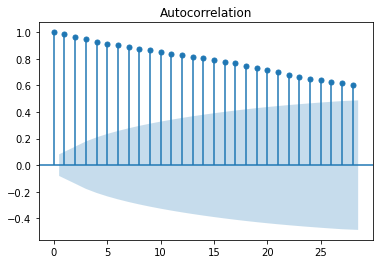

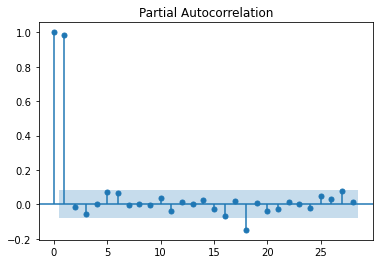

In [19]:
plot_acf(samsung) # ACF plot
plot_pacf(samsung) # PACF plot
plt.show()

In [20]:
y = samsung['close']
y_1diff = samsung.diff().dropna()['close']
result = adfuller(y)
print(f'원 데이터 ADF Statistic : {result[0] : .4f}')
print(f'원 데이터 p-value : {result[1] : .4f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic : {result[0] : .4f}')
print(f'1차 차분 p-value : {result[1] : .4f}')

원 데이터 ADF Statistic : -1.6797
원 데이터 p-value :  0.4416
1차 차분 ADF Statistic : -15.6033
1차 차분 p-value :  0.0000


In [21]:
model = ARIMA(samsung, order=(1,1,0)) # freq='D'
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  580
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4740.925
Method:                       css-mle   S.D. of innovations            858.399
Date:                Mon, 14 Sep 2020   AIC                           9487.849
Time:                        07:07:35   BIC                           9500.938
Sample:                             1   HQIC                          9492.952
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.2441     35.371      0.346      0.729     -57.081      81.569
ar.L1.D.close    -0.0077      0.042     -0.186      0.852      -0.089       0.074
                                    Root

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [22]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(3):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

predictions
#plt.plot(test.index, test['close'])
#plt.plot(test.index, predictions, color='red')
#plt.show()

[array([59013.88239263]), array([59026.10032556]), array([59038.28418205])]

In [23]:
def auto_arima(data, order, sort='AIC'):
    order_lst = []
    aic_lst = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    order_lst.append(c_order)
                    aic_lst.append(aic)
                except:
                    pass
    result_auto = pd.DataFrame(list(zip(order_lst, aic_lst)), columns=['order', 'AIC'])
    result_auto.sort_values(sort, inplace=True)
    return result_auto

result = auto_arima(samsung, [3,3,3])
result

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency infor

c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\ilifo-028\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency infor

,order,AIC
25,p2 d2 q1,9477.074032
7,p0 d2 q1,9477.542153
26,p2 d2 q2,9478.828742
16,p1 d2 q1,9479.499972
8,p0 d2 q2,9479.506244
17,p1 d2 q2,9479.757320
5,p0 d1 q2,9485.081841
21,p2 d1 q0,9485.399002
3,p0 d1 q0,9485.883724
14,p1 d1 q2,9486.955777


In [24]:
# rolling forecast
history = [x for x in samsung['close']]
predictions = []
for i in range(3):
    model = ARIMA(history, order=(0,2,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

predictions
#plt.plot(test.index, test['close'])
#plt.plot(test.index, predictions, color='red')
#plt.show()

[array([59084.7502107]), array([59169.26524081]), array([59254.03245999])]

In [25]:
#samsung.index[-1] + pd.Timedelta(days=1)

In [156]:
!jupyter nbconvert --to script 0914_stock_predict.ipynb

[NbConvertApp] Converting notebook 0914_stock_predict.ipynb to script
[NbConvertApp] Writing 9575 bytes to 0914_stock_predict.py
